<a href="https://colab.research.google.com/github/LucaBarco/Homework2-Caltech101/blob/master/TransferLearningHomework2_MLDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [1]:
'''!pip3 install 'torch==1.5.0'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm' '''

"!pip3 install 'torch==1.5.0'\n!pip3 install 'torchvision==0.5.0'\n!pip3 install 'Pillow-SIMD'\n!pip3 install 'tqdm' "

**Import libraries**

In [2]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [3]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.005            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 50      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 35     # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [4]:
# Define transforms for training phase
'''train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])'''
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

#transfer learning -- 
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

**Prepare Dataset**

**Prepare Dataloaders**

In [5]:
# Clone github repository with data
! rm -r 'Caltech101'
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/LucaBarco/Homework2-Caltech101
  !mv 'Homework2-Caltech101' 'Caltech101'
DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech
# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

#train_indexes,val_indexes = train_dataset.split_training_set()
train_indexes=range(0,len(train_dataset),2)
val_indexes=range(1,len(train_dataset),2)

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)


# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 9398 (delta 18), reused 10 (delta 4), pack-reused 9366
Receiving objects: 100% (9398/9398), 130.30 MiB | 41.28 MiB/s, done.
Resolving deltas: 100% (89/89), done.
Checking out files: 100% (9156/9156), done.
train Ho contato 5784 immagini
test Ho contato 2893 immagini
Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


In [6]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [7]:
#net = alexnet() # Loading AlexNet model
net=torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True) #use alexnet

net.classifier[4] = nn.Linear(4096,1024)
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(1024, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


**Prepare Training**

In [8]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [9]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
# Start iterating over the epochs
for epoch in tqdm(range(NUM_EPOCHS)):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Step the scheduler
  scheduler.step() 

  0%|          | 0/50 [00:00<?, ?it/s]

Starting epoch 1/50, LR = [0.005]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.991246223449707


  2%|▏         | 1/50 [00:08<07:10,  8.78s/it]

Step 10, Loss 3.2109925746917725
Starting epoch 2/50, LR = [0.005]
Step 20, Loss 2.218616008758545


  4%|▍         | 2/50 [00:17<07:00,  8.77s/it]

Starting epoch 3/50, LR = [0.005]
Step 30, Loss 1.5688843727111816


  6%|▌         | 3/50 [00:25<06:48,  8.68s/it]

Starting epoch 4/50, LR = [0.005]
Step 40, Loss 0.7350757718086243


  8%|▊         | 4/50 [00:34<06:39,  8.68s/it]

Starting epoch 5/50, LR = [0.005]
Step 50, Loss 0.4544999599456787


 10%|█         | 5/50 [00:43<06:32,  8.71s/it]

Starting epoch 6/50, LR = [0.005]
Step 60, Loss 0.34633857011795044


 12%|█▏        | 6/50 [00:52<06:22,  8.70s/it]

Starting epoch 7/50, LR = [0.005]
Step 70, Loss 0.1656140387058258


 14%|█▍        | 7/50 [01:01<06:19,  8.82s/it]

Starting epoch 8/50, LR = [0.005]
Step 80, Loss 0.13761083781719208


 16%|█▌        | 8/50 [01:10<06:11,  8.84s/it]

Starting epoch 9/50, LR = [0.005]
Step 90, Loss 0.12384913116693497


 18%|█▊        | 9/50 [01:18<05:56,  8.69s/it]

Starting epoch 10/50, LR = [0.005]
Step 100, Loss 0.042082104831933975


 20%|██        | 10/50 [01:27<05:46,  8.67s/it]

Starting epoch 11/50, LR = [0.005]
Step 110, Loss 0.03459944576025009


 22%|██▏       | 11/50 [01:35<05:39,  8.72s/it]

Step 120, Loss 0.09567196667194366
Starting epoch 12/50, LR = [0.005]
Step 130, Loss 0.06355178356170654


 24%|██▍       | 12/50 [01:44<05:34,  8.79s/it]

Starting epoch 13/50, LR = [0.005]
Step 140, Loss 0.03931702673435211


 26%|██▌       | 13/50 [01:53<05:26,  8.82s/it]

Starting epoch 14/50, LR = [0.005]
Step 150, Loss 0.035658497363328934


 28%|██▊       | 14/50 [02:02<05:16,  8.79s/it]

Starting epoch 15/50, LR = [0.005]
Step 160, Loss 0.04971436411142349


 30%|███       | 15/50 [02:11<05:06,  8.75s/it]

Starting epoch 16/50, LR = [0.005]
Step 170, Loss 0.04102899506688118


 32%|███▏      | 16/50 [02:19<04:56,  8.73s/it]

Starting epoch 17/50, LR = [0.005]
Step 180, Loss 0.017134197056293488


 34%|███▍      | 17/50 [02:28<04:48,  8.73s/it]

Starting epoch 18/50, LR = [0.005]
Step 190, Loss 0.019187064841389656


 36%|███▌      | 18/50 [02:37<04:39,  8.73s/it]

Starting epoch 19/50, LR = [0.005]
Step 200, Loss 0.019195521250367165


 38%|███▊      | 19/50 [02:45<04:28,  8.67s/it]

Starting epoch 20/50, LR = [0.005]
Step 210, Loss 0.03667726740241051


 40%|████      | 20/50 [02:54<04:21,  8.70s/it]

Starting epoch 21/50, LR = [0.005]
Step 220, Loss 0.03028268553316593


 42%|████▏     | 21/50 [03:03<04:10,  8.65s/it]

Step 230, Loss 0.017562346532940865
Starting epoch 22/50, LR = [0.005]
Step 240, Loss 0.010561920702457428


 44%|████▍     | 22/50 [03:11<04:00,  8.60s/it]

Starting epoch 23/50, LR = [0.005]
Step 250, Loss 0.022925108671188354


 46%|████▌     | 23/50 [03:20<03:54,  8.68s/it]

Starting epoch 24/50, LR = [0.005]
Step 260, Loss 0.010802088305354118


 48%|████▊     | 24/50 [03:29<03:48,  8.79s/it]

Starting epoch 25/50, LR = [0.005]
Step 270, Loss 0.01883033849298954


 50%|█████     | 25/50 [03:38<03:40,  8.83s/it]

Starting epoch 26/50, LR = [0.005]
Step 280, Loss 0.00810026004910469


 52%|█████▏    | 26/50 [03:47<03:32,  8.85s/it]

Starting epoch 27/50, LR = [0.005]
Step 290, Loss 0.020838527008891106


 54%|█████▍    | 27/50 [03:56<03:24,  8.90s/it]

Starting epoch 28/50, LR = [0.005]
Step 300, Loss 0.028468020260334015


 56%|█████▌    | 28/50 [04:05<03:16,  8.94s/it]

Starting epoch 29/50, LR = [0.005]
Step 310, Loss 0.018255479633808136


 58%|█████▊    | 29/50 [04:14<03:07,  8.94s/it]

Starting epoch 30/50, LR = [0.005]
Step 320, Loss 0.003947982098907232


 60%|██████    | 30/50 [04:23<02:57,  8.87s/it]

Starting epoch 31/50, LR = [0.005]
Step 330, Loss 0.010010749101638794


 62%|██████▏   | 31/50 [04:31<02:46,  8.78s/it]

Step 340, Loss 0.0029498422518372536
Starting epoch 32/50, LR = [0.005]
Step 350, Loss 0.02817799337208271


 64%|██████▍   | 32/50 [04:40<02:36,  8.72s/it]

Starting epoch 33/50, LR = [0.005]
Step 360, Loss 0.005946172866970301


 66%|██████▌   | 33/50 [04:49<02:28,  8.75s/it]

Starting epoch 34/50, LR = [0.005]
Step 370, Loss 0.0037467009387910366


 68%|██████▊   | 34/50 [04:57<02:20,  8.80s/it]

Starting epoch 35/50, LR = [0.005]
Step 380, Loss 0.012715015560388565


 70%|███████   | 35/50 [05:06<02:11,  8.74s/it]

Starting epoch 36/50, LR = [5e-05]
Step 390, Loss 0.019283141940832138


 72%|███████▏  | 36/50 [05:15<02:02,  8.75s/it]

Starting epoch 37/50, LR = [0.0005]
Step 400, Loss 0.003087050514295697


 74%|███████▍  | 37/50 [05:23<01:52,  8.64s/it]

Starting epoch 38/50, LR = [0.0005]
Step 410, Loss 0.020667005330324173


 76%|███████▌  | 38/50 [05:32<01:43,  8.61s/it]

Starting epoch 39/50, LR = [0.0005]
Step 420, Loss 0.005521770566701889


 78%|███████▊  | 39/50 [05:41<01:35,  8.69s/it]

Starting epoch 40/50, LR = [0.0005]
Step 430, Loss 0.011441799812018871


 80%|████████  | 40/50 [05:49<01:27,  8.71s/it]

Starting epoch 41/50, LR = [0.0005]
Step 440, Loss 0.00920735765248537


 82%|████████▏ | 41/50 [05:58<01:18,  8.72s/it]

Step 450, Loss 0.004319092258810997
Starting epoch 42/50, LR = [0.0005]
Step 460, Loss 0.040084850043058395


 84%|████████▍ | 42/50 [06:07<01:09,  8.68s/it]

Starting epoch 43/50, LR = [0.0005]
Step 470, Loss 0.0018447848269715905


 86%|████████▌ | 43/50 [06:15<01:00,  8.63s/it]

Starting epoch 44/50, LR = [0.0005]
Step 480, Loss 0.011360187083482742


 88%|████████▊ | 44/50 [06:24<00:51,  8.54s/it]

Starting epoch 45/50, LR = [0.0005]
Step 490, Loss 0.005445438902825117


 90%|█████████ | 45/50 [06:32<00:43,  8.61s/it]

Starting epoch 46/50, LR = [0.0005]
Step 500, Loss 0.004215477965772152


 92%|█████████▏| 46/50 [06:41<00:34,  8.57s/it]

Starting epoch 47/50, LR = [0.0005]
Step 510, Loss 0.000897200545296073


 94%|█████████▍| 47/50 [06:50<00:26,  8.69s/it]

Starting epoch 48/50, LR = [0.0005]
Step 520, Loss 0.00512362364679575


 96%|█████████▌| 48/50 [06:58<00:17,  8.70s/it]

Starting epoch 49/50, LR = [0.0005]
Step 530, Loss 0.015368785709142685


 98%|█████████▊| 49/50 [07:07<00:08,  8.71s/it]

Starting epoch 50/50, LR = [0.0005]
Step 540, Loss 0.001572502893395722


100%|██████████| 50/50 [07:16<00:00,  8.73s/it]


**Validation**

In [10]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
print(str(len(val_dataloader)))
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy))

  0%|          | 0/12 [00:00<?, ?it/s]

12


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]

Validation Accuracy: 0.8772475795297372


**Test**

In [11]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:08<00:00,  1.36it/s]

Test Accuracy: 0.808848945731075


['accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'Faces', 'Faces_easy', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'Leopards', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'Motorbikes', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball', 'stapler

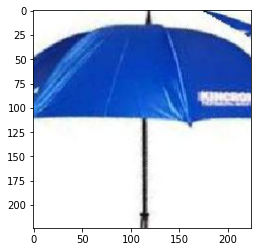

			umbrella


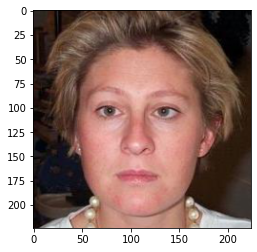

			Faces_easy


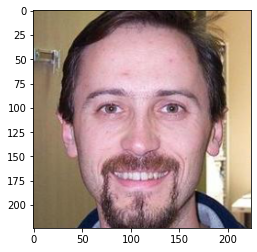

			Faces_easy


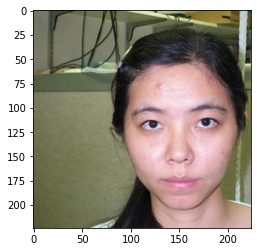

			Faces


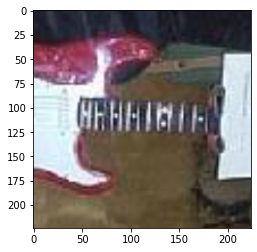

			cup


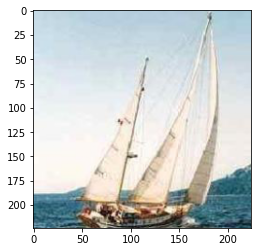

			ketch


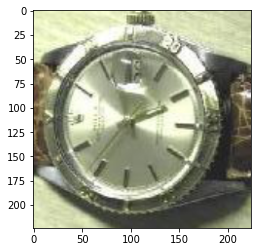

			watch


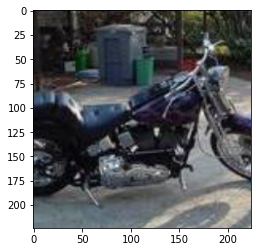

			Motorbikes


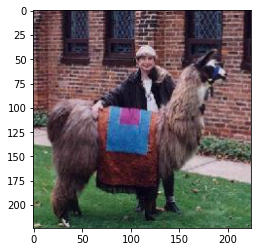

			llama


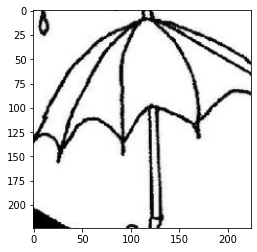

			umbrella


In [12]:
import matplotlib.pyplot as plt
import random 
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

labels=list(test_dataset.return_labels())
print (labels)
#Get some random training images
for i in range(0,10):
  index=len(test_dataset)-1
  image,label=test_dataset[random.randint(0,index)]
  imagex = image.unsqueeze(0)
  imageCuda=imagex.to(DEVICE)
  outputs = net(imageCuda)
  preds = torch.max(outputs.data, 1)
  imshow(image)
  print( "\t\t\t"+labels[preds.indices.cpu().numpy()[0]])